In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent
from tqdm import tqdm

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
#from utils.environment.CIgame import GraphGame
#from utils.reinforcement_learning.CIGraphNN import CIGraphNN
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    fh = open(graph_path+str(file)+".txt", "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(nx.relabel_nodes(GRAPH, map))   
    return GRAPH

def CV_evaluation(graph_path, model_path,filename, parameter_path):  
    params = Params(parameter_path)
    _NUM_PLAYERS = 2
    file_list = []
    AUC = []
    x_label = []
    start = int(params.save_every)
    end = int(params.num_train_episodes)+start
    interval = int(params.save_every)
    for iteration in np.arange(start,end,interval):
        name = model_path+str(iteration)
        loading_attacker = torch.load(name)
        auc_individual = []
        for file in filename:
            GRAPH = input_graph(graph_path,file)
            N = len(GRAPH)
            game = "graph_attack_defend"
            env = Environment(game)
            num_actions = env.action_spec()["num_actions"]
            attacker = DQN(player_id=0,
                            state_representation_size=params.centrality_features,
                            hidden_layers_sizes= params.hidden_layers,
                           global_feature_size =params.global_features,
                           num_actions=num_actions)
            attacker._q_network.load_state_dict(loading_attacker["_q_network"])
            attacker._optimizer.load_state_dict(loading_attacker["_optimizer"])
            agents = [attacker,attacker]
            rewards, lcc, actions = EvaluateModel(env,agents,GRAPH)
            #Compute Area under the curve
            x =  np.flip(np.arange(N)[N:0:-1]/N)
            auc_individual.append(area_under_curve(x[:len(lcc)],lcc))
        AUC.append(np.mean(auc_individual))
        x_label.append(iteration)
    AUC = np.array(AUC)
    x_label = np.array(x_label)
    return x_label, AUC

# Results

In [2]:
model_path = ["../model/DiffSize_BA_Graph/model_BAGraph_","../model/DiffSize_Different_Graph/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
results = []
for path in tqdm(range(2)):
    graph_path ="../Dataset/Validation/"
    filename = ['homogeneous_' + str(i) for i in range(10)]
    x, homogeneous = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    filename = ['heterogeneous_' + str(i) for i in range(10)]
    x,heterogeneous = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    results.append([homogeneous,heterogeneous])

100%|█████████████████████████████████████████| 2/2 [4:05:43<00:00, 7371.88s/it]


In [3]:
def lowest_AUC(x, CV_homo, CV_hetero):
    cond =True
    while cond:
        homog = np.argmin(CV_homo)
        heterog = np.argmin(CV_hetero)
        if homog != heterog:
            CV_homo = np.delete(CV_homo, homog)
            CV_hetero = np.delete(CV_hetero, heterog)
            x = np.delete(x, homog)
        else:
            return x[homog]
        
def lowest_AUC_each(x, CV_homo, CV_hetero):
    homog = np.argmin(CV_homo)
    heterog = np.argmin(CV_hetero)
    return x[homog], x[heterog]
        
results = np.array(results)
save_every= 500            
num_train_episodes = int(5e5) 
x = np.arange(500,num_train_episodes+save_every,save_every)
print(results.shape)
print("BA Graph")
print(lowest_AUC(x, results[0,0,0:int(num_train_episodes/save_every)], results[0,1,0:int(num_train_episodes/save_every)]))
print(lowest_AUC_each(x, results[0,0,0:int(num_train_episodes/save_every)], results[0,1,0:int(num_train_episodes/save_every)]))
print("Different Graph")
print(lowest_AUC(x, results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]))
print(lowest_AUC_each(x, results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]))



(2, 2, 1000)
BA Graph
377500
(97000, 31500)
Different Graph
26500
(27500, 41500)


Homogeneous_BA


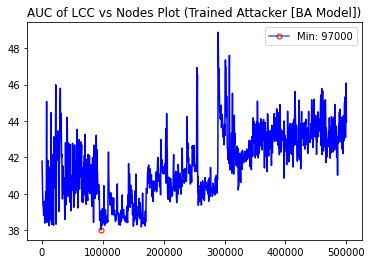

Heterogeneous_BA


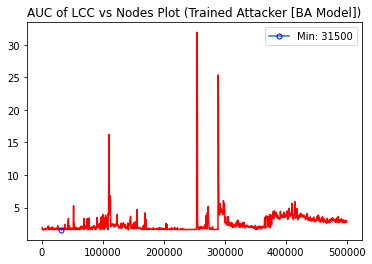

Homogeneous_Diff


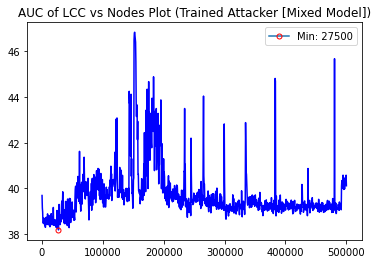

Heterogeneous_Diff


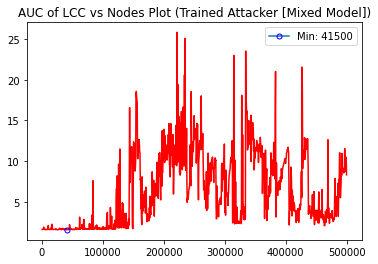

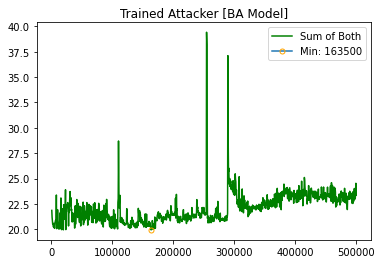

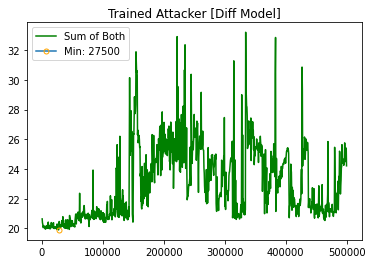

In [4]:
for i in range(2):
    for j in range(2):
        if j == 0:
            color = 'blue'
            label = 'Homogeneous'
            inv = 'red'
        else:
            color = 'red'
            label = 'Heterogeneous'
            inv = 'blue'
        if i == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"
        else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"
        min_value = np.argmin(results[i,j,0:int(num_train_episodes/save_every)])
        #print(x[np.argsort(results[i,j,0:int(num_train_episodes/save_every)])])
        #print(x[np.argsort(results[i,j,0:int(num_train_episodes/save_every)])])
        min_vc = x[min_value]
        plt.plot(x, results[i,j,0:int(num_train_episodes/save_every)], color)
        plt.plot(min_vc, results[i,j,min_value], marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
        plt.title("AUC of LCC vs Nodes Plot "+""+str(name))
        plt.legend()
        print(label+"_"+save)
        plt.savefig("./Figure/Validation/eval_"+label+"_"+save)
        plt.show()
sum_both = np.mean([results[0,0,0:int(num_train_episodes/save_every)],results[0,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Sum of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]
plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [BA Model]')
plt.legend()
plt.savefig("./Figure/Validation/eval_Homogenity_BA")
plt.show()
sum_both = np.mean([results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Sum of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]

plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [Diff Model]')
plt.legend()
plt.savefig("./Figure/Validation/eval_Homogenity_Mixed")
plt.show()
        

Homogeneous_BA


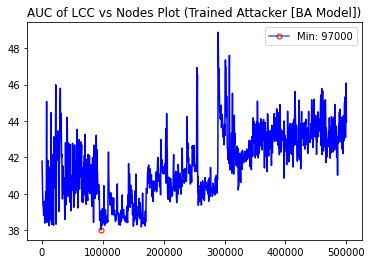

Heterogeneous_BA


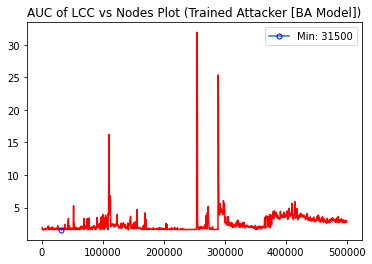

Homogeneous_Diff


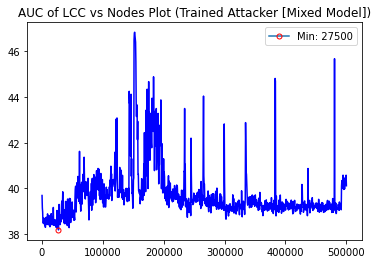

Heterogeneous_Diff


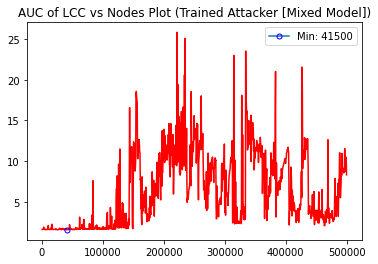

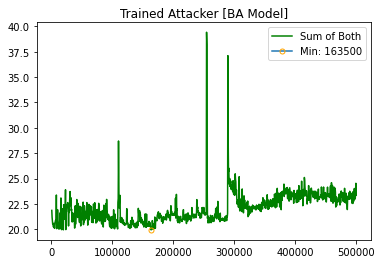

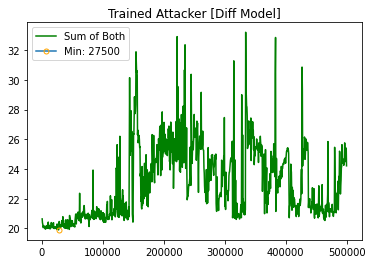

In [5]:
for i in range(2):
    for j in range(2):
        if j == 0:
            color = 'blue'
            label = 'Homogeneous'
            inv = 'red'
        else:
            color = 'red'
            label = 'Heterogeneous'
            inv = 'blue'
        if i == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"
        else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"
        min_value = np.argmin(results[i,j,0:int(num_train_episodes/save_every)])
        #print(x[np.argsort(results[i,j,0:int(num_train_episodes/save_every)])])
        #print(x[np.argsort(results[i,j,0:int(num_train_episodes/save_every)])])
        min_vc = x[min_value]
        plt.plot(x, results[i,j,0:int(num_train_episodes/save_every)], color)
        plt.plot(min_vc, results[i,j,min_value], marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
        plt.title("AUC of LCC vs Nodes Plot "+""+str(name))
        plt.legend()
        print(label+"_"+save)
        plt.savefig("./Figure/Validation/eval_"+label+"_"+save)
        plt.show()
sum_both = np.mean([results[0,0,0:int(num_train_episodes/save_every)],results[0,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Sum of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]
plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [BA Model]')
plt.legend()
plt.savefig("./Figure/Validation/eval_Homogenity_BA")
plt.show()
sum_both = np.mean([results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Sum of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]

plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [Diff Model]')
plt.legend()
plt.savefig("./Figure/Validation/eval_Homogenity_Mixed")
plt.show()
        

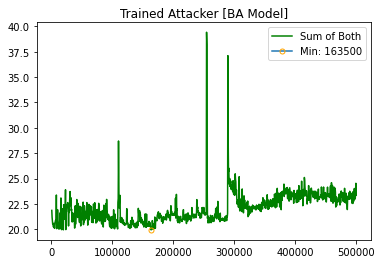

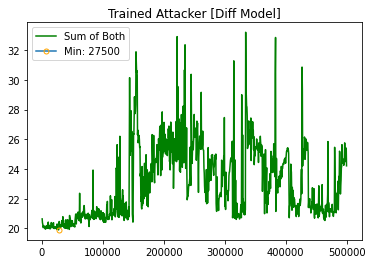

In [6]:
sum_both = np.mean([results[0,0,0:int(num_train_episodes/save_every)],results[0,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Sum of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]
#print(x[np.argsort(sum_both)])
plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [BA Model]')
plt.legend()
plt.show()
sum_both = np.mean([results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Sum of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]
#print(x[np.argsort(sum_both)])
plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [Diff Model]')
plt.legend()
plt.show()